In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls
%cd ./drive/MyDrive
! ls
! cp img_align_celeba.zip /content
! cp list_attr_celeba.txt /content
# from path will differ depending on where you saved the zip file in Google Drive
! unzip -DD -q  /content/img_align_celeba.zip -d  /content/
! cp /content/list_attr_celeba.txt /content/img_align_celeba

drive  sample_data
/content/drive/MyDrive
'Colab Notebooks'	 img_align_celeba.zip   save_img_1.zip	 unconditional_model.pt
 gender_conditional.pt	 list_attr_celeba.txt   save_img.zip


In [4]:
############### PICK ONE ################
#dataroot = "/scratch/<BU user name>/img_align_celeba/" # if on SCC
dataroot = "img_align_celeba/" # if on colab
%cd /content
! ls

/content
drive  img_align_celeba  img_align_celeba.zip  list_attr_celeba.txt  sample_data


In [124]:
from __future__ import print_function
import os, math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_class
import torchvision
from PIL import Image
from copy import deepcopy


# The CelebA dataset contains 40 binary attribute labels for each image
attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows',
 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs',
 'Big_Lips', 'Big_Nose', 'Black_Hair',
 'Blond_Hair', 'Blurry', 'Brown_Hair',
 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face',
 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat',
 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie',
 'Young']

def set_random_seed(seed=999):
    # Set random seed for reproducibility
    print("Random Seed: ", seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [125]:
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        '''Initialize the dataset.'''
        self.transform = transform
        self.root = dataroot
        self.attr_txt = dataroot + 'list_attr_celeba.txt'
        self._parse()

    def _parse(self):
        '''
        Parse the celeba text file.
        Pupulate the following private variables:
         - self.ys: A list of 1D tensors with 40 binary attribute labels.
         - self.im_paths: A list of strings (image paths).
        '''
        self.im_paths = [] # list of jpeg filenames
        self.ys = []       # list of attribute labels

        def _to_binary(lst):
            return torch.tensor([0 if lab == '-1' else 1 for lab in lst])

        with open(self.attr_txt) as f:
            for line in f:
                assert len(line.strip().split()) == 41
                fl = line.strip().split()
                if fl[0][-4:] == '.jpg': # if not header

                    self.im_paths.append(self.root + fl[0]) # jpeg filename
                    self.ys.append(_to_binary(fl[1:]))      # 1D tensor of 40 binary attributes

    def __len__(self):
        '''Return length of the dataset.'''
        return len(self.ys)

    def __getitem__(self, index):
        '''
        Return the (image, attributes) tuple.
        This function gets called when you index the dataset.
        '''
        def img_load(index):
            imraw = Image.open(self.im_paths[index])
            im = self.transform(imraw)
            return im

        target = self.ys[index]
        return img_load(index), target

In [126]:
def nonlinearity(x):
    ''' Also called the activation function. '''
    # swish
    return x*torch.sigmoid(x)
    # Swish is similar to GeLU. People tend to use this more than ReLU nowadays.

class Block(nn.Module):
    '''
    This implements a residual block.
    It has a similar structure to the residual block used in ResNets,
    but there are a few modern modifications:
     - Different order of applying weights, activations, and normalization.
     - Swish instead of ReLU activation.
     - GroupNorm instead of BatchNorm.
    We also need to add the conditional embedding.

    '''
    def __init__(self, in_channels, out_channels, emb_dim=256):
        '''
        in_channels: Number of image channels in input.
        out_channels: Number of image channels in output.
        emb_dim: Length of conditional embedding vector.
        '''
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.norm1 = nn.GroupNorm(1, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.proj = nn.Linear(emb_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, t):
        '''
        h and x have dimension B x C x H x W,
        where B is batch size,
              C is channel size,
              H is height,
              W is width.
        t is the conditional embedding.
        t has dimension B x V,
        where V is the embedding dimension.
        '''
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)
        h = h + nonlinearity(self.proj(t))[:,:,None,None]
        h = nonlinearity(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            x = self.shortcut(x)

        return x+h

In [127]:
class Down(nn.Module):
    ''' Downsampling block.'''
    def __init__(self, in_channels, out_channels):
        '''
        This block downsamples the feature map size by 2.
        in_channels: Number of image channels in input.
        out_channels: Number of image channels in output.
        '''
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = Block(in_channels, out_channels)

    def forward(self, x, t):
        ''' x is the feature maps; t is the conditional embeddings. '''
        x = self.pool(x) # The max pooling decreases feature map size by factor of 2
        x = self.conv(x, t)
        return x

class Up(nn.Module):
    ''' Upsampling block.'''
    def __init__(self, in_channels, out_channels):
        '''
        This block upsamples the feature map size by 2.
        in_channels: Number of image channels in input.
        out_channels: Number of image channels in output.
        '''
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = Block(in_channels, out_channels)

    def forward(self, x, skip_x, t):
        '''
        x is the feature maps;
        skip_x is the skipp connection feature maps;
        t is the conditional embeddings.
        '''
        x = self.up(x) # The upsampling increases the feature map size by factor of 2
        x = torch.cat([skip_x, x], dim=1) # concatentate skip connection
        x = self.conv(x, t)
        return x

In [128]:
class UNet(nn.Module):
    ''' UNet implementation of a denoising auto-encoder.'''
    def __init__(self, c_in=3, c_out=3, conditional=True, emb_dim=256,marginal_prob_std=None):
        '''
        c_in: Number of image channels in input.
        c_out: Number of image channels in output.
        emb_dim: Length of conditional embedding vector.
        '''
        super().__init__()
        self.emb_dim = emb_dim
        self.inc = Block(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)

        self.bot1 = Block(256, 512)
        self.bot2 = Block(512, 512)
        self.bot3 = Block(512, 512)
        self.bot4 = Block(512, 256)

        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        self.marginal_prob_std = marginal_prob_std
        # nn.Embedding implements a dictionary of num_classes prototypes
        self.conditional = conditional
        if conditional:
            num_classes = 2

            self.gender = nn.Parameter(torch.randn(num_classes, emb_dim))

    def temporal_encoding(self, timestep):
        '''
        This implements the sinusoidal temporal encoding for the current timestep.
        Input timestep is a tensor of length equal to the batch size
        Output emb is a 2D tensor B x V,
            where V is the embedding dimension.
        '''

        assert len(timestep.shape) == 1
        half_dim = self.emb_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        emb = emb.to(device=timestep.device)
        emb = timestep.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.emb_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0,1,0,0))
        return emb

    def unet_forward(self, x, t):
        # x: B x 3 x 224 x 224
        x1 = self.inc(x, t)    # x1: B x 64 x 64 x 64
        x2 = self.down1(x1, t) # x2: B x 128 x 32 x 32
        x3 = self.down2(x2, t) # x3: B x 256 x 16 x 16
        x4 = self.down3(x3, t) # x3: B x 256 x 8 x 8

        x4 = self.bot1(x4, t) # x4: B x 512 x 8 x 8
        # Removing bot2 and bot3 can save some time at the expense of quality
        x4 = self.bot2(x4, t) # x4: B x 512 x 8 x 8
        x4 = self.bot3(x4, t) # x4: B x 512 x 8 x 8
        x4 = self.bot4(x4, t) # x4: B x 256 x 8 x 8

        x = self.up1(x4, x3, t) # x: B x 128 x 16 x 16
        x = self.up2(x, x2, t)  # x: B x 64 x 32 x 32
        x = self.up3(x, x1, t)  # x: B x 64 x 64 x 64
        output = self.outc(x)   # x: B x 3 x 64 x 64
        return output

    def forward(self, x, t, y=None):
        '''
        x: image input
        t: integer timestep
        y: binary conditioning
        Return denoised image conditioned on the timestep t and
            class label y.
        '''
        if self.conditional:

            temporal_encoding = self.temporal_encoding(t)

            if y is not None:
                # Calculate the gender vector
                gender_vector = self.gender[y]

                # Add the temporal encoding and gender vector to get the final conditional vector
                c = temporal_encoding + gender_vector
            else:
                c = temporal_encoding

        else:
            c = self.temporal_encoding(t)

        return self.unet_forward(x, c)

In [129]:
class Diffusion:
    '''
    Implements the Diffusion process,
    including both training and sampling.
    '''
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        ################## YOUR CODE HERE ##################
        # Here you should instantiate a 1D vector called self.beta,
        # which contains the \beta_t values
        # We use 1000 time steps, so t = 1:1000
        # \beta_1 = 1e-4
        # \beta_1000 = 0.02
        # The value of beta should increase linearly w.r.t. the value of t.
        #
        # Additionally, it may be helpful to pre-calculate the values of
        # \alpha_t and \bar{\alpha}_t here, since you'll use them often.
        ####################################################
        self.beta = torch.linspace(beta_start,beta_end,num_timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    def get_noisy_image(self, x_0, t):
        '''`
        This function is only used for training.

        x_0: The input image. Dimensions: B x 3 x H x W
        t: A 1D vector of length B representing the desired timestep
          B is the batch size.
          H and W are the height and width of the input image.

        This function returns a *tuple of TWO tensors*:
            (x_t, epsilon)
            both have dimensions B x 3 x H x W
        '''
        ################## YOUR CODE HERE ##################
        # Calculate x_t from x_0 and t based on the equation you derived in problem 1.
        # Remember that \epsilon in the equation is noise drawn from
        # a standard normal distribution.
        # *** Return BOTH x_t and \epsilon as a tuple ***.
        ####################################################


        eps = torch.randn_like(x_0).to(self.device)
        alpha_t = self.alpha[t]
        alpha_bar_t = self.alpha_bar[t]
        x_t = torch.sqrt(alpha_bar_t)[:,None,None,None] * x_0 + torch.sqrt(1 - alpha_bar_t)[:,None,None,None] * eps
        return (x_t, eps)
    def sample(self, model, n, y=None):
        '''
        This function is used  to generate images.

        model: The denoising auto-encoder \epsilon_{\theta}
        n: The number of images you want to generate
        y: A 1D binary vector of size n indicating the
            desired gender for the generated face.
        '''
        model.eval()

        with torch.no_grad():
            ################## YOUR CODE HERE ##################
            # Write code for the sampling process here.
            # This process starts with x_T and progresses to x_0, T=1000
            # Reference *Algorithm 2* in "Denoising Diffusion Probabilistic Models" by Jonathan Ho et al.
            #
            # Start with x_T drawn from the standard normal distribution.
            # x_T has dimensions n x 3 x H x W.
            # H = W = 64 are the dimensions of the image for this assignment.
            #
            # Then for t = 1000 -> 1
            #     (1) Call the model to calculate \epsilon_{\theta}(x_t, t)
            #     (2) Use the formula from above to calculate \mu_{\theta} from \epsilon_{\theta}
            #     (3) Add zero-mean Gaussian noise with variance \beta_t to \mu_{\theta}
            #         this yields x_{t-1}
            #
            # Skip step (3) if t=1, because x_0 is the final image. It makes no sense to add noise to
            # the final product.
            ####################################################
            T = self.num_timesteps
            H = self.img_size
            W = self.img_size
            x_T = torch.randn(n, 3, H, W, device=self.device)
            for k in range(T):
                t = T-k-1
                if t == (T-1):
                  x_t = x_T

                epsilon = model(x_t, (torch.ones(n)*t).long().to(self.device), y)

                mu = (1/torch.sqrt(self.alpha[t]))*(x_t - self.beta[t]*epsilon/torch.sqrt(1-self.alpha_bar[t]))
                if t>0:
                  x_t = torch.randn_like(mu, device=self.device)*torch.sqrt(self.beta[t]) + mu
            x=x_t
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

def show_images(images, **kwargs):
    plt.figure(figsize=(10, 10), dpi=80)
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    plt.imshow(im)
    plt.show()

In [130]:
class EMA:
    '''
    This class implements the Expontial Moving Average (EMA) for model weights.
    Only used for evaluation.
    Using the EMA averaged model increases the quality of generated images.
    '''
    def __init__(self, beta=0.995):
        '''
        beta is a hyperparameter.
        New model weights = beta * (old model weights) +
                            (1 - beta) * (new model weights)
        '''
        super().__init__()
        self.beta = beta

    def step_ema(self, ma_model, current_model):
        '''
        ma_model: the averaged model we will use for evaluation
        current_model: The model being explicitly trained
        This function updates the weights of ma_model. Return None.
        '''
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        '''Private function used to update individual parameters.'''
        return old * self.beta + (1 - self.beta) * new

In [131]:
# We will resize to 64 x 64 for this assignment
image_size = 64

# Hyperparameters
batch_size = 64
learning_rate = 0.0002
weight_decay = 0.00001 # (L2 penalty)

# Transform used for training
train_transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5)),
                           ])

# Make the dataset
dataset = CelebADataset(transform=train_transform)

# index of the binary attribute for gender
gender_index = attributes.index('Male')

# Run on GPU
device = 'cuda'

In [132]:
# Instantiate denoising autoencoder
model = UNet().to(device)

# ema_model is the averaged model that we'll use for sampling
ema_model = deepcopy(model)

# ema is the helper for updaing EMA weights
ema = EMA()

# Dataloader
trainloader = torch.utils.data.DataLoader(dataset, drop_last=True,  batch_size=batch_size, shuffle=True, num_workers=8)

# Mixed precision floating point arithmetic can speed up training on some GPUs
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Diffusion wrapper
diffusion = Diffusion(img_size=image_size, device=device)

In [117]:
! pip install functools

  Using cached functools-0.5.tar.gz (4.9 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for functools
  Running setup.py clean for functools
Failed to build functools
ERROR: Could not build wheels for functools, which is required to install pyproject.toml-based projects


In [133]:
#@title Set up the SDE
import functools
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [134]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)

  std = marginal_prob_std(random_t)

  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm.notebook


#score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = torch.nn.DataParallel(UNet(marginal_prob_std = marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}



trainloader = torch.utils.data.DataLoader(dataset, drop_last=True,  batch_size=batch_size, shuffle=True, num_workers=8)





optimizer = Adam(score_model.parameters(), lr=lr)

for epoch in range(10):
  avg_loss = 0.
  num_items = 0
  pbar = tqdm.tqdm(trainloader)
  count =0
  for x, y in pbar:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/6331 [00:00<?, ?it/s]<ipython-input-133-947b5f2c8c88>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
 13%|█▎        | 853/6331 [01:54<11:14,  8.12it/s]

In [54]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 64, 64, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

In [55]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 64, 64, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

In [56]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 3, 64, 64, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:

from torchvision.utils import make_grid
score_model = torch.nn.DataParallel(UNet(marginal_prob_std = marginal_prob_std_fn))
score_model = score_model.to(device)
## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
temp = samples
samples = samples.clamp(0.0, 1.0)
%matplotlib inline

import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.gender", "module.inc.norm1.weight", "module.inc.norm1.bias", "module.inc.conv1.weight", "module.inc.proj.weight", "module.inc.proj.bias", "module.inc.conv2.weight", "module.inc.shortcut.weight", "module.inc.shortcut.bias", "module.down1.conv.norm1.weight", "module.down1.conv.norm1.bias", "module.down1.conv.conv1.weight", "module.down1.conv.proj.weight", "module.down1.conv.proj.bias", "module.down1.conv.conv2.weight", "module.down1.conv.shortcut.weight", "module.down1.conv.shortcut.bias", "module.down2.conv.norm1.weight", "module.down2.conv.norm1.bias", "module.down2.conv.conv1.weight", "module.down2.conv.proj.weight", "module.down2.conv.proj.bias", "module.down2.conv.conv2.weight", "module.down2.conv.shortcut.weight", "module.down2.conv.shortcut.bias", "module.down3.conv.norm1.weight", "module.down3.conv.norm1.bias", "module.down3.conv.conv1.weight", "module.down3.conv.proj.weight", "module.down3.conv.proj.bias", "module.down3.conv.conv2.weight", "module.down3.conv.shortcut.weight", "module.down3.conv.shortcut.bias", "module.bot1.norm1.weight", "module.bot1.norm1.bias", "module.bot1.conv1.weight", "module.bot1.proj.weight", "module.bot1.proj.bias", "module.bot1.conv2.weight", "module.bot1.shortcut.weight", "module.bot1.shortcut.bias", "module.bot2.norm1.weight", "module.bot2.norm1.bias", "module.bot2.conv1.weight", "module.bot2.proj.weight", "module.bot2.proj.bias", "module.bot2.conv2.weight", "module.bot2.shortcut.weight", "module.bot2.shortcut.bias", "module.bot3.norm1.weight", "module.bot3.norm1.bias", "module.bot3.conv1.weight", "module.bot3.proj.weight", "module.bot3.proj.bias", "module.bot3.conv2.weight", "module.bot3.shortcut.weight", "module.bot3.shortcut.bias", "module.bot4.norm1.weight", "module.bot4.norm1.bias", "module.bot4.conv1.weight", "module.bot4.proj.weight", "module.bot4.proj.bias", "module.bot4.conv2.weight", "module.bot4.shortcut.weight", "module.bot4.shortcut.bias", "module.up1.conv.norm1.weight", "module.up1.conv.norm1.bias", "module.up1.conv.conv1.weight", "module.up1.conv.proj.weight", "module.up1.conv.proj.bias", "module.up1.conv.conv2.weight", "module.up1.conv.shortcut.weight", "module.up1.conv.shortcut.bias", "module.up2.conv.norm1.weight", "module.up2.conv.norm1.bias", "module.up2.conv.conv1.weight", "module.up2.conv.proj.weight", "module.up2.conv.proj.bias", "module.up2.conv.conv2.weight", "module.up2.conv.shortcut.weight", "module.up2.conv.shortcut.bias", "module.up3.conv.norm1.weight", "module.up3.conv.norm1.bias", "module.up3.conv.conv1.weight", "module.up3.conv.proj.weight", "module.up3.conv.proj.bias", "module.up3.conv.conv2.weight", "module.up3.conv.shortcut.weight", "module.up3.conv.shortcut.bias", "module.outc.weight", "module.outc.bias". 
	Unexpected key(s) in state_dict: "module.embed.0.W", "module.embed.1.weight", "module.embed.1.bias", "module.conv1.weight", "module.dense1.dense.weight", "module.dense1.dense.bias", "module.gnorm1.weight", "module.gnorm1.bias", "module.conv2.weight", "module.dense2.dense.weight", "module.dense2.dense.bias", "module.gnorm2.weight", "module.gnorm2.bias", "module.conv3.weight", "module.dense3.dense.weight", "module.dense3.dense.bias", "module.gnorm3.weight", "module.gnorm3.bias", "module.conv4.weight", "module.dense4.dense.weight", "module.dense4.dense.bias", "module.gnorm4.weight", "module.gnorm4.bias", "module.tconv4.weight", "module.dense5.dense.weight", "module.dense5.dense.bias", "module.tgnorm4.weight", "module.tgnorm4.bias", "module.tconv3.weight", "module.dense6.dense.weight", "module.dense6.dense.bias", "module.tgnorm3.weight", "module.tgnorm3.bias", "module.tconv2.weight", "module.dense7.dense.weight", "module.dense7.dense.bias", "module.tgnorm2.weight", "module.tgnorm2.bias", "module.tconv1.weight", "module.tconv1.bias". 

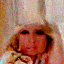

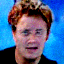

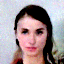

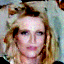

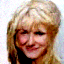

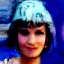

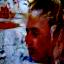

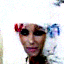

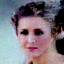

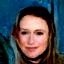

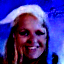

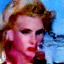

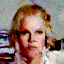

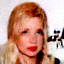

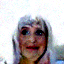

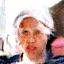

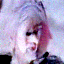

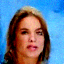

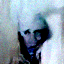

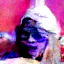

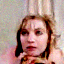

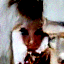

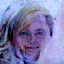

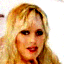

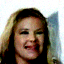

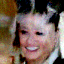

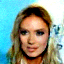

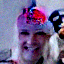

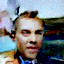

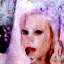

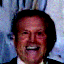

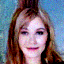

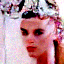

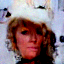

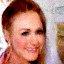

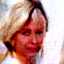

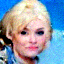

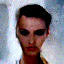

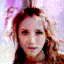

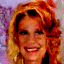

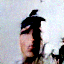

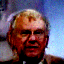

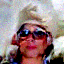

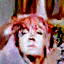

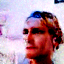

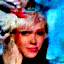

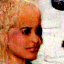

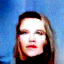

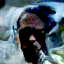

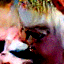

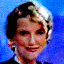

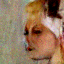

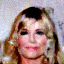

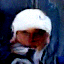

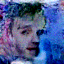

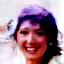

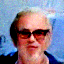

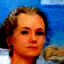

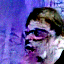

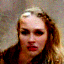

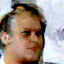

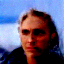

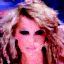

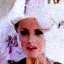

<Figure size 600x600 with 0 Axes>

In [ ]:
r"""
  @misc{Seitzer2020FID,
    author={Maximilian Seitzer},
    title={{pytorch-fid: FID Score for PyTorch}},
    month={August},
    year={2020},
    note={Version 0.3.0},
    howpublished={\url{https://github.com/mseitzer/pytorch-fid}},
  }
"""
temp=temp.clamp(0.0,1.0)
plt.figure(figsize=(6,6))
for i in range(sample_batch_size):
  sample_grid = make_grid(samples[i], nrow=int(np.sqrt(sample_batch_size)))

  img = torchvision.transforms.ToPILImage()(sample_grid)
  img.show()
  torchvision.utils.save_image(sample_grid, './save_img/img%s.jpg' % i)


In [ ]:
opendir = "./img_align_celeba/"
for i in os.listdir(opendir):
  image = Image.open(opendir+i)
  convert_tensor = transforms.ToTensor()
  image=convert_tensor(image)
  transform = torchvision.transforms.Resize(64)
  image = transform(image)

  torchvision.utils.save_image(image, "save_img_1/"+i)

UnidentifiedImageError: ignored

In [ ]:
!python -m pytorch_fid save_img_1 save_img


100% 3269/3269 [10:47<00:00,  5.05it/s]
100% 2/2 [00:00<00:00,  3.79it/s]
FID:  159.16554023371293
